# Imports

In [2]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import col

from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import IntegerType, FloatType, StringType,StructType, StructField

import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.modeling.preprocessing import KBinsDiscretizer, OrdinalEncoder, OneHotEncoder
from snowflake.ml.modeling.impute import SimpleImputer
from snowflake.ml.utils.connection_params import SnowflakeLoginOptions

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import json
import os
import pandas as pd
from datetime import date, timedelta

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
session = Session.builder.configs(SnowflakeLoginOptions()).getOrCreate()

SnowflakeLoginOptions() is in private preview since 0.2.0. Do not use it in production. 


# Snowflake Setup: Create a Database and Schema

We will be using PUBLIC schema.

In [4]:
# Load TS data from Store_Traffic Database into ACCRUENT_TS_FORECASTING DB for testing purposes.
session.use_database('store_traffic')
session.use_schema('time_series')

sdf_raw = session.table('traffic')

In [5]:
# Print the Number of Time Series/Pumps that we have to predict
session.sql('SELECT COUNT(DISTINCT store_id) FROM traffic').collect()

[Row(COUNT(DISTINCT STORE_ID)=1000)]

In [6]:
sdf_raw.limit(5).to_pandas()

,DATE,STORE_ID,TRAFFIC
0,2020-01-01,1,125
1,2020-01-02,1,145
2,2020-01-03,1,148
3,2020-01-04,1,139
4,2020-01-05,1,113


# Local Testing

In [7]:
df_data = sdf_raw.filter((F.col("store_id") == 62)).to_pandas()

# Here onwards copy paste in UDTF
df_data['DATE'] = pd.to_datetime(df_data['DATE'])
df_data.groupby('DATE').sum('TRAFFIC').reset_index()
# df_data = df_data[['DATE','VALUE']]
df_data = df_data.sort_values(by=['DATE']).reset_index(drop=True)

In [8]:
df_data.head()

,DATE,STORE_ID,TRAFFIC
0,2020-01-01,62,80
1,2020-01-02,62,93
2,2020-01-03,62,95
3,2020-01-04,62,89
4,2020-01-05,62,72


<Axes: xlabel='DATE'>

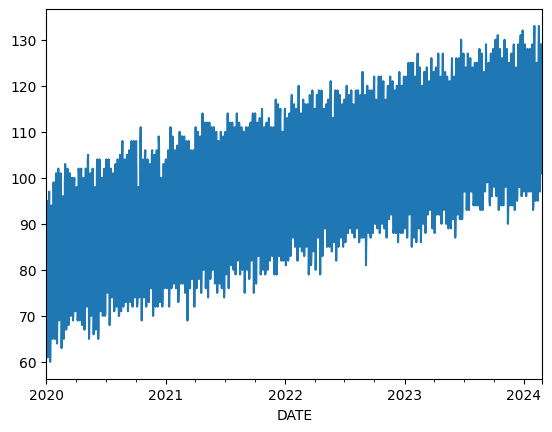

In [9]:
df_data.set_index('DATE')['TRAFFIC'].plot()

### Testing with Nixtla MLForecast

In [10]:
df_mlf = df_data.copy()
df_mlf.columns = ['ds', 'unique_id', 'y']
df_mlf.tail(5)

,ds,unique_id,y
1513,2024-02-22,62,129
1514,2024-02-23,62,129
1515,2024-02-24,62,119
1516,2024-02-25,62,106
1517,2024-02-26,62,101


In [11]:
fcst = MLForecast(
    models=[LinearRegression(),XGBRegressor(), RandomForestRegressor()],
    freq='D',  # our series has a daily frequency
    lags=[1,7,28,60],
    target_transforms=[Differences([1,365])],
)

#fit up until 14 days ago this gives us 2 weeks to compare 
fcst.fit(df_mlf.iloc[0:-14])

MLForecast(models=[LinearRegression, XGBRegressor, RandomForestRegressor], freq=<Day>, lag_features=['lag1', 'lag7', 'lag28', 'lag60'], date_features=[], num_threads=1)

In [12]:
# Predict 28 days that way we can have 2 weeks for comparison and 2 weeks forecasted out
preds = fcst.predict(28)
preds

,unique_id,ds,LinearRegression,XGBRegressor,RandomForestRegressor
0,62,2024-02-13,98.215363,96.217171,97.45
1,62,2024-02-14,107.813530,110.338295,107.86
2,62,2024-02-15,126.044144,131.377472,127.55
3,62,2024-02-16,126.945534,136.067810,130.41
4,62,2024-02-17,117.956314,125.729736,120.31
5,62,2024-02-18,103.958214,105.600571,102.32
6,62,2024-02-19,94.059059,95.927666,91.32
7,62,2024-02-20,96.694809,96.653328,93.42
8,62,2024-02-21,110.317039,107.838364,106.26
9,62,2024-02-22,123.453690,119.019043,120.99


In [13]:
df_res = preds.merge(df_mlf, left_on=['ds','unique_id'], right_on = ['ds','unique_id'],how='left')
df_res = df_res.drop('unique_id', axis=1)

In [14]:
df_res.head()

,ds,LinearRegression,XGBRegressor,RandomForestRegressor,y
0,2024-02-13,98.215363,96.217171,97.45,99.0
1,2024-02-14,107.813530,110.338295,107.86,113.0
2,2024-02-15,126.044144,131.377472,127.55,129.0
3,2024-02-16,126.945534,136.067810,130.41,133.0
4,2024-02-17,117.956314,125.729736,120.31,123.0


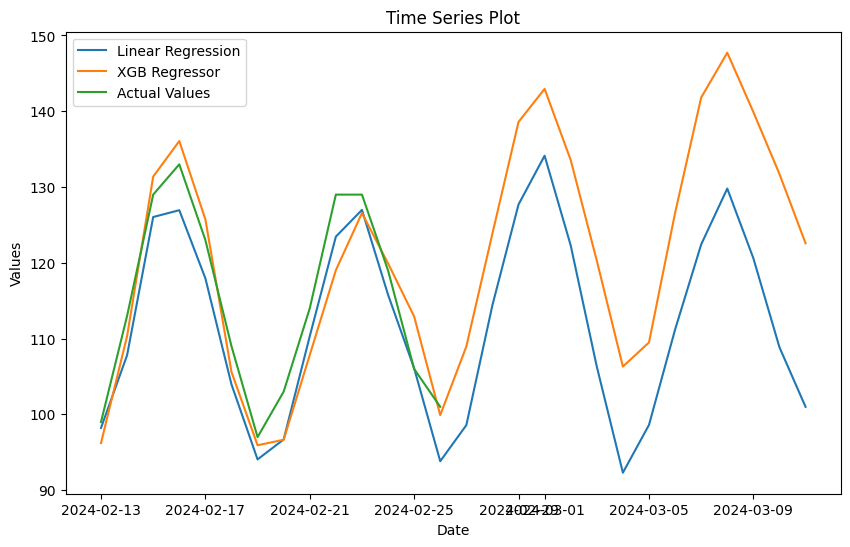

In [15]:
df = df_res.copy()
df.set_index('ds', inplace=True)

# Plotting the time series
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['LinearRegression'], label='Linear Regression')
plt.plot(df.index, df['XGBRegressor'], label='XGB Regressor')
plt.plot(df.index, df['y'], label='Actual Values')

# Adding title and labels
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Values')

# Adding legend
plt.legend()

# Display the plot
plt.show()


# Creating UDTF for multi-node parallelized model training

In [16]:
session.sql('create stage if not exists pymodels').collect()

[Row(status='PYMODELS already exists, statement succeeded.')]

In [17]:
schema = T.StructType([
    T.StructField("ID", T.IntegerType()),
    T.StructField("TIMESTAMP", T.DateType()),
    T.StructField("LINREG", T.FloatType()),
    T.StructField("XGB", T.FloatType()),
    T.StructField("TRAIN_START", T.DateType()),
    T.StructField("TRAIN_END", T.DateType()),
    T.StructField("FORECAST_HORIZON", T.IntegerType())
                  ])

@F.udtf(output_schema = schema,
        input_types = [T.VariantType()],
        name = "TSF_MLFORECAST", is_permanent=True, stage_location= "@pymodels", session=session,
        packages=['pandas', 'mlforecast' ,'xgboost', 'scikit-learn'],
        replace=True
       )

class forecast:
    def __init__(self):
        self.rows=[]
        self.dfs=[]
    
    def process(self, data):
        self.rows.append(data)

        # Merge rows into a dataframe
        if len(self.rows) >= 16000:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []
        
        # Merge dataframes into a single dataframe
        # Minimizes memory footprint
        if len(self.dfs) >= 100:
            merged_df = pd.concat(self.dfs)
            self.dfs = [merged_df]

        yield None
    
    def end_partition(self):
        # Merge any remaining rows
        from mlforecast import MLForecast
        from mlforecast.target_transforms import Differences
        from xgboost import XGBRegressor
        from sklearn.linear_model import LinearRegression

        if len(self.rows) > 0:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []

        # Process Input
        df_input = pd.concat(self.dfs)
        df_input['DATE'] = pd.to_datetime(df_input['DATE'])
        df_input.groupby(['DATE','STORE_ID']).sum('TRAFFIC').reset_index()
        df_input = df_input[['DATE','STORE_ID','TRAFFIC']]
        df_input.columns = ['ds','unique_id','y']

        #Train + Forecast Length
        train_end = max(df_input['ds']) - pd.Timedelta(days = 14)
        train_start = max(df_input['ds']) 
        # or you can choose to only go back so far 
        train_end - pd.Timedelta(days = 600)
        
        df_input = df_input.loc[(df_input['ds'] >= train_start) &
                                (df_input['ds'] < train_end)].reset_index(drop=True)

        
        fcst = MLForecast(models=[LinearRegression(),XGBRegressor()],
                          freq='D',
                          lags=[1,7,28,60],
                          target_transforms=[Differences([1])])
        
        fcst.fit(df_mlf.iloc[0:-14])

        ts_forecast = fcst.predict(28)
        
        # Processing
        ts_forecast.columns = ['ID','TIMESTAMP','LINREG','XGB']
        ts_forecast['TRAIN_START'] = train_start
        ts_forecast['TRAIN_END'] = train_end
        ts_forecast['FORECAST_HORIZON'] = 28

        yield from ts_forecast.itertuples(index=False, name=None) 

In [18]:
sdf_raw.limit(5).to_pandas()

,DATE,STORE_ID,TRAFFIC
0,2020-01-01,1,125
1,2020-01-02,1,145
2,2020-01-03,1,148
3,2020-01-04,1,139
4,2020-01-05,1,113


In [21]:
df = session.table('TRAFFIC') \
        .with_column('ROW', F.object_construct_keep_null('*')) \
        .select(F.col('STORE_ID'), F.col('ROW'))

store_forecast_test = F.table_function("TSF_MLFORECAST")

variant_column = F.parse_json(df.col('ROW').cast(T.VariantType()))

forecast = df.select(
                F.col('STORE_ID'), 
                store_forecast_test(variant_column).over(partition_by=['STORE_ID'])
                )

forecast = forecast.with_column('FORECAST_DATETIME', F.current_timestamp())
forecast.write.save_as_table("FORECAST_USING_MLFORECAST", mode="append")

In [22]:
sdf_ref = session.table('FORECAST_USING_MLFORECAST')
sdf_ref.limit(5).to_pandas()

,STORE_ID,ID,TIMESTAMP,LINREG,XGB,TRAIN_START,TRAIN_END,FORECAST_HORIZON,FORECAST_DATETIME
0,937,62,2024-02-13,96.590240,99.832695,2024-02-26,2024-02-12,28,2024-02-27 16:15:56.036000-08:00
1,937,62,2024-02-14,110.492630,111.575668,2024-02-26,2024-02-12,28,2024-02-27 16:15:56.036000-08:00
2,937,62,2024-02-15,121.261703,125.696129,2024-02-26,2024-02-12,28,2024-02-27 16:15:56.036000-08:00
3,937,62,2024-02-16,124.699692,128.795639,2024-02-26,2024-02-12,28,2024-02-27 16:15:56.036000-08:00
4,937,62,2024-02-17,115.697769,117.887749,2024-02-26,2024-02-12,28,2024-02-27 16:15:56.036000-08:00


In [23]:
session.sql('''
create or replace table MLFORECAST_actual_vs_forecast as
select timestamp as date, a.store_id, linreg, xgb, traffic as actual
from FORECAST_USING_MLFORECAST a
left join traffic b
on a.store_id = b.store_id
and a.timestamp = b.date;
            ''').collect()

[Row(status='Table MLFORECAST_ACTUAL_VS_FORECAST successfully created.')]

In [27]:
# View a random Store
session.table('MLFORECAST_actual_vs_forecast').filter(F.col('store_id')==200).show()

--------------------------------------------------------------------------------
|"DATE"      |"STORE_ID"  |"LINREG"            |"XGB"               |"ACTUAL"  |
--------------------------------------------------------------------------------
|2024-02-13  |200         |96.59024047851562   |99.83269500732422   |94        |
|2024-02-14  |200         |110.49263000488281  |111.57566833496094  |108       |
|2024-02-15  |200         |121.26170349121094  |125.69612884521484  |123       |
|2024-02-16  |200         |124.69969177246094  |128.79563903808594  |127       |
|2024-02-17  |200         |115.69776916503906  |117.88774871826172  |117       |
|2024-02-18  |200         |104.04916381835938  |105.77021789550781  |103       |
|2024-02-19  |200         |94.09197235107422   |95.58452606201172   |92        |
|2024-02-20  |200         |96.48123168945312   |99.14708709716797   |98        |
|2024-02-21  |200         |111.4466781616211   |111.76410675048828  |109       |
|2024-02-22  |200         |1